In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
#%matplotlib qt
%matplotlib inline

simulation_L = 125

In [3]:
# method to get all halo values
def get_values(index, minmass=0):
    # mask values
    mask = np.logical_and((name==index), (m>minmass))
    mvir, rvir, x, y, z = m[mask], r[mask], x_pos[mask], y_pos[mask], z_pos[mask]
    
    mask_x = (x-x[0]>2*rvir[0])
    #print(mask_x)
    x[mask_x]=x[mask_x]-simulation_L
    
    mask_x_case2 = (x[0]-x>2*rvir[0])
    x[mask_x_case2] = simulation_L+x[mask_x_case2]
    
    mask_z = (z-z[0]>2*rvir[0])
    z[mask_z]=z[mask_z]-simulation_L
    
    mask_z_case2 = (z[0]-z>2*rvir[0])
    z[mask_z_case2] = simulation_L+z[mask_z_case2]
    
    mask_y = (y-y[0]>2*rvir[0])
    y[mask_y]=y[mask_y]-simulation_L
    
    mask_y_case2 = (y[0]-y>2*rvir[0])
    y[mask_y_case2] = simulation_L+y[mask_y_case2]
    
    return mvir, rvir, x, y, z

In [4]:
# method to calculate ellipsoid axes
def get_axes(data, nonzerocenter = True):
    # define coordinates relative to center halo
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]
    
    if nonzerocenter:
        x = x[1:]-x[0]
        y = y[1:]-y[0]
        z = z[1:]-z[0]
    
    # setup
    M = np.zeros((3,3))
    # print(M)
    
    # calculate elements of tensor
    M[0][0] = np.sum(y**2 + z**2)
    M[1][1] = np.sum(z**2 + x**2)
    M[2][2] = np.sum(x**2 + y**2)
    M[0][1] = M[1][0] = -np.sum(x*y)
    M[0][2] = M[2][0] = -np.sum(x*z)
    M[1][2] = M[2][1] = -np.sum(y*z)
    
    # get eigenvalues + moments of inertia
    eigenvalues, eigenvectors = np.linalg.eig(M)
    I_a = eigenvalues[0] * 5 / x.shape[0]
    I_b = eigenvalues[1] * 5 / x.shape[0]
    I_c = eigenvalues[2] * 5 / x.shape[0]
    
    # calculate axes
    axes = np.zeros(3)
    axes[1] = np.sqrt((I_a - I_b + I_c)/2)
    axes[2] = np.sqrt(I_a - (axes[1]**2))
    axes[0] = np.sqrt(I_c - (axes[1]**2))
    
    #if np.isnan(np.sum(axes)):
        #print(axes)
    
    ordered_axes = np.sort(axes)
    ordered_axes = ordered_axes[::-1]
    
    return ordered_axes

In [10]:
def get_ca(data):
    # format: x, y, z in an array
    a, b, c = get_axes(data)
    return c/a

def get_mean_pos(data):
    return np.mean(np.abs(data[1:]-data[0]), axis=0)

# mean function
def mean(data):
    return np.mean(data, axis=0)

In [6]:
def bootstrap(dataset):
    """
    Method to perform bootstrap sampling on a dataset.
    """
    indices = np.arange(len(dataset))
    random_index = np.random.choice(indices[1:], len(dataset), replace=True)
    random_index[0] = 0
    return dataset[random_index]

In [7]:
# method to repeat bootstrap sampling
def get_statistics(dataset, repetitions, function):
    all_axes = []
    
    # for each sample, calculate axes
    for i in range(repetitions):
        sample = bootstrap(dataset)
        output = function(sample)
        all_axes.append(output)
    
    # return all axes
    return np.array(all_axes)

In [8]:
# method to get 1sigma, 2sigma, 3sigma quantiles
def get_quantiles(data):
    quantiles = {'median': np.quantile(data,0.5),
                 '1sigma': [np.quantile(data,0.159),np.quantile(data,0.841)],
                 '2sigma': [np.quantile(data, 0.023),np.quantile(data,0.977)],
                 '3sigma': [np.quantile(data,0.002),np.quantile(data,0.998)]}
    return quantiles

In [12]:
def get_mean_pos(data):
    return np.mean(np.abs(data[1:]-data[0]), axis=0)

def get_mean_dist(data):
    xdist, ydist, zdist = get_mean_pos(data)
    return np.sqrt(xdist**2 + ydist**2 + zdist**2)

In [19]:
name, m, r, x_pos, y_pos, z_pos = np.loadtxt("Chinchilla_L125_e1.txt",usecols=(0,1,2,6,7,8)).T
n = np.logspace(-5,-2,num=100)
names = np.unique(name)
mean_vals = np.zeros(len(n))
sds_vals = np.zeros(len(n))


for i in range(len(n)):
    print(i)
    vals = np.zeros(len(names))
    
    for j in range(len(names)):
        halo = names[j]
        mass, radius, x, y, z = get_values(halo)
        mass, radius, x, y, z = get_values(halo, minmass=n[i]*mass[0])
        if mass.shape[0]>1:
            halo_data_bootstrapped = get_statistics(np.array([x,y,z]).T, 1000, get_mean_dist)
            quantiles = get_quantiles(halo_data_bootstrapped/radius[0])
            vals[j] = quantiles['median']
    
    mean_vals[i] = np.mean(vals)
    sds_vals[i] = np.std(vals)

d_e1_mean = mean_vals
d_e1_sds = sds_vals

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [20]:
name, m, r, x_pos, y_pos, z_pos = np.loadtxt("Chinchilla_L125_e2.txt",usecols=(0,1,2,6,7,8)).T
n = np.logspace(-5,-2,num=100)
names = np.unique(name)
mean_vals = np.zeros(len(n))
sds_vals = np.zeros(len(n))


for i in range(len(n)):
    print(i)
    vals = np.zeros(len(names))
    
    for j in range(len(names)):
        halo = names[j]
        mass, radius, x, y, z = get_values(halo)
        mass, radius, x, y, z = get_values(halo, minmass=n[i]*mass[0])
        if mass.shape[0]>1:
            halo_data_bootstrapped = get_statistics(np.array([x,y,z]).T, 1000, get_mean_dist)
            quantiles = get_quantiles(halo_data_bootstrapped/radius[0])
            vals[j] = quantiles['median']
    
    mean_vals[i] = np.mean(vals)
    sds_vals[i] = np.std(vals)

d_e2_mean = mean_vals
d_e2_sds = sds_vals

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [21]:
name, m, r, x_pos, y_pos, z_pos = np.loadtxt("Chinchilla_L125_e5.txt",usecols=(0,1,2,6,7,8)).T
n = np.logspace(-5,-2,num=100)
names = np.unique(name)
mean_vals = np.zeros(len(n))
sds_vals = np.zeros(len(n))


for i in range(len(n)):
    print(i)
    vals = np.zeros(len(names))
    
    for j in range(len(names)):
        halo = names[j]
        mass, radius, x, y, z = get_values(halo)
        mass, radius, x, y, z = get_values(halo, minmass=n[i]*mass[0])
        if mass.shape[0]>1:
            halo_data_bootstrapped = get_statistics(np.array([x,y,z]).T, 1000, get_mean_dist)
            quantiles = get_quantiles(halo_data_bootstrapped/radius[0])
            vals[j] = quantiles['median']
    
    mean_vals[i] = np.mean(vals)
    sds_vals[i] = np.std(vals)

d_e5_mean = mean_vals
d_e5_sds = sds_vals

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [23]:
name, m, r, x_pos, y_pos, z_pos = np.loadtxt("Chinchilla_L125_e14.txt",usecols=(0,1,2,6,7,8)).T
n = np.logspace(-5,-2,num=100)
names = np.unique(name)
mean_vals = np.zeros(len(n))
sds_vals = np.zeros(len(n))


for i in range(len(n)):
    print(i)
    vals = np.zeros(len(names))
    
    for j in range(len(names)):
        halo = names[j]
        mass, radius, x, y, z = get_values(halo)
        mass, radius, x, y, z = get_values(halo, minmass=n[i]*mass[0])
        if mass.shape[0]>1:
            halo_data_bootstrapped = get_statistics(np.array([x,y,z]).T, 1000, get_mean_dist)
            quantiles = get_quantiles(halo_data_bootstrapped/radius[0])
            vals[j] = quantiles['median']
    
    mean_vals[i] = np.mean(vals)
    sds_vals[i] = np.std(vals)

d_e14_mean = mean_vals
d_e14_sds = sds_vals

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [19]:
ca_e1_mean

NameError: name 'ca_e1_mean' is not defined

Text(0.5, 0, '$MinMass/M_{vir} (M_\\odot)$')

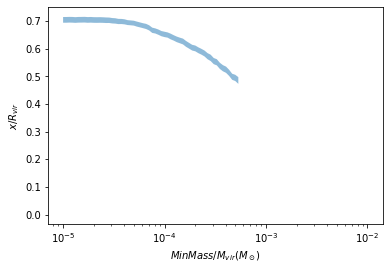

In [16]:
yerr = sds_vals/np.sqrt(len(names))
plt.fill_between(n, mean_vals+yerr, mean_vals-yerr, alpha=0.5)
plt.xscale('log')
plt.ylabel(r'$x/R_{vir}$')
plt.xlabel(r'$MinMass/M_{vir} (M_\odot)$')

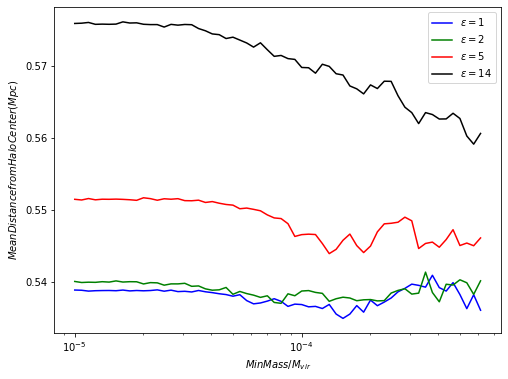

In [24]:
fig = plt.figure(figsize=(8,6))
e1 = plt.plot(n[:60], d_e1_mean[:60], label=r'$\varepsilon=1$', c='b')
e2 = plt.plot(n[:60], d_e2_mean[:60], label=r'$\varepsilon=2$', c='g')
e3 = plt.plot(n[:60], d_e5_mean[:60], label=r'$\varepsilon=5$', c='r')
e14 = plt.plot(n[:60], d_e14_mean[:60], label=r'$\varepsilon=14$', c='k')

plt.xscale('log')
plt.ylabel(r'$Mean Distance from Halo Center (Mpc)$')
plt.xlabel(r'$MinMass/M_{vir}$')
plt.legend()

In [ ]:
fig = plt.figure(figsize=(8,6))
e1 = plt.plot(n[:60], ca_e1_mean[:60], label=r'$\varepsilon=1$', c='b')
e2 = plt.plot(n[:60], ca_e2_mean[:60], label=r'$\varepsilon=2$', c='g')
e3 = plt.plot(n[:60], ca_e5_mean[:60], label=r'$\varepsilon=5$', c='r')
e14 = plt.plot(n[:60], ca_e14_mean[:60], label=r'$\varepsilon=14$', c='k')

plt.xscale('log')
plt.ylabel(r'$c/a$')
plt.xlabel(r'$MinMass/M_{vir}$')
plt.legend()

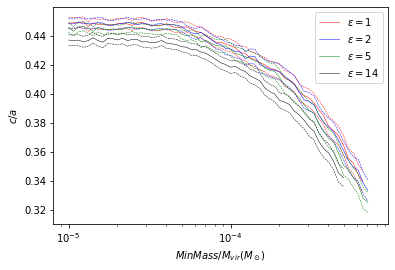

In [111]:
yerr = ca_e1_sds/np.sqrt(nhalos_1)
plt.plot(n, ca_e1_mean-yerr, 'r--', lw=0.5)
e1 = plt.plot(n, ca_e1_mean, c='r', lw=0.5, label=r'$\varepsilon=1$')
plt.plot(n, ca_e1_mean+yerr, 'r--', lw=0.5)

yerr = ca_e2_sds/np.sqrt(nhalos_2)
plt.plot(n, ca_e2_mean-yerr, 'b--', lw=0.5)
e2 = plt.plot(n, ca_e2_mean, c='b', lw=0.5, label=r'$\varepsilon=2$')
plt.plot(n, ca_e2_mean+yerr, 'b--', lw=0.5)

yerr = ca_e5_sds/np.sqrt(nhalos_5)
plt.plot(n, ca_e5_mean-yerr, 'g--', lw=0.5)
e5 = plt.plot(n, ca_e5_mean, c='g', lw=0.5, label=r'$\varepsilon=5$')
plt.plot(n, ca_e5_mean+yerr, 'g--', lw=0.5)

yerr = ca_e14_sds/np.sqrt(nhalos_14)
plt.plot(n, ca_e14_mean-yerr, 'k--', lw=0.5)
e14 = plt.plot(n, ca_e14_mean, c='k', lw=0.5, label=r'$\varepsilon=14$')
plt.plot(n, ca_e14_mean+yerr, 'k--', lw=0.5)

plt.xscale('log')
plt.ylabel(r'$c/a$')
plt.xlabel(r'$MinMass/M_{vir} (M_\odot)$')
plt.legend()

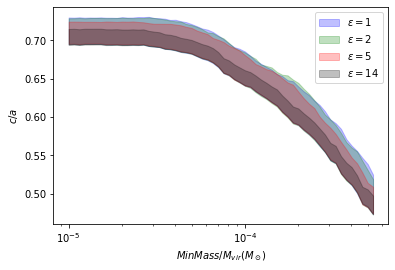

In [19]:
yerr = ca_e1_sds/np.sqrt(50)
e1 = plt.fill_between(n, ca_e1_mean+yerr, mean_vals-yerr, color='b', alpha=0.25, label=r'$\varepsilon=1$')

yerr = ca_e2_sds/np.sqrt(50)
e2 = plt.fill_between(n, ca_e2_mean+yerr, mean_vals-yerr, color='g', alpha=0.25, label=r'$\varepsilon=2$')

yerr = ca_e5_sds/np.sqrt(50)
e3 = plt.fill_between(n, ca_e5_mean+yerr, mean_vals-yerr, color='r', alpha=0.25, label=r'$\varepsilon=5$')

yerr = ca_e14_sds/np.sqrt(50)
e14 = plt.fill_between(n, ca_e14_mean+yerr, mean_vals-yerr, color='k', alpha=0.25, label=r'$\varepsilon=14$')

plt.xscale('log')
plt.ylabel(r'$c/a$')
plt.xlabel(r'$MinMass/M_{vir} (M_\odot)$')
plt.legend()

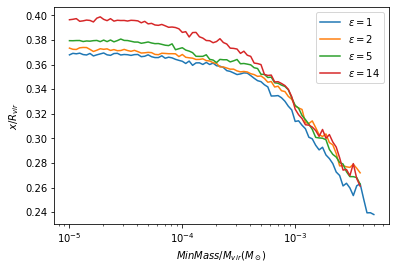

In [78]:
e1 = plt.plot(n, xrvir_e1_mean, label=r'$\varepsilon=1$')


e2 = plt.plot(n, xrvir_e2_mean, label=r'$\varepsilon=2$')

e3 = plt.plot(n, xrvir_e5_mean, label=r'$\varepsilon=5$')

e14 = plt.plot(n, xrvir_e14_mean, label=r'$\varepsilon=14$')

plt.xscale('log')
plt.ylabel(r'$x/R_{vir}$')
plt.xlabel(r'$MinMass/M_{vir} (M_\odot)$')
plt.legend()

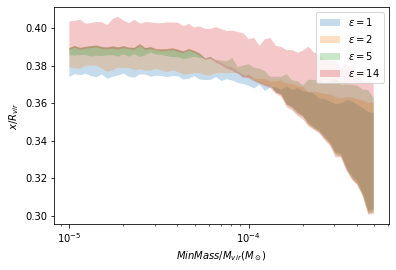

In [82]:
yerr = xrvir_e1_sds/np.sqrt(nhalos_1)
e1 = plt.fill_between(n, xrvir_e1_mean+yerr, mean_vals-yerr, alpha=0.25, label=r'$\varepsilon=1$')

yerr = xrvir_e2_sds/np.sqrt(nhalos_2)
e2 = plt.fill_between(n, xrvir_e2_mean+yerr, mean_vals-yerr, alpha=0.25, label=r'$\varepsilon=2$')

yerr = xrvir_e5_sds/np.sqrt(nhalos_5)
e5 = plt.fill_between(n, xrvir_e5_mean+yerr, mean_vals-yerr, alpha=0.25, label=r'$\varepsilon=5$')

yerr = xrvir_e14_sds/np.sqrt(nhalos_14)
e14 = plt.fill_between(n, xrvir_e14_mean+yerr, mean_vals-yerr, alpha=0.25, label=r'$\varepsilon=14$')

plt.xscale('log')
plt.ylabel(r'$x/R_{vir}$')
plt.xlabel(r'$MinMass/M_{vir} (M_\odot)$')
plt.legend()